<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/concrete/force_moment_interaction/force_moment_interaction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

# Seismic Forces on Floor Diaphragms

<img src="../../../assets/img/structure/structural_dynamics/seismic_forces_on_floor_diaphragms/seismic_forces_on_floor_diaphragm_concrete_slab.jpg" width=100% alt="Frame properties">

# Seismic Forces on Floor Diaphragms



## Setup Environment

In [1]:
# !pip install comtypes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import comtypes.client

## Define Structural Model

### Seismic Design Parameters

* Location: San Diego, CA (Lat: 32.71576, Long: -117.163817)
* Soil Class: D-Stiff Soil ($V_{S30}=260$)
* Risk Category: II
* $PGA_{M}=0.69$
* $T_L=8$ sec
* $S_S = 1.65$
* $S_1 = 0.5$
* $S_{MS}=1.64$
* $S_{M1}=1.19$
* $S_{DS}=1.09$
* $S_{D1}=0.79$

### Loads

* Dead load: 95 psf (including 6" concrete slab)
* Live load: 50 psf (office)
* Roof live load: 20 psf
* Tributary width: 18 ft

### Model Parameters

* Lateral force resisting: Steel special moment-resisting frame
* $R=8$
* $\Omega_0=3$
* $C_d=5.5$
* $I_e=1.0$

The section used for beams and columns are as follows:

|Story|1|2|3|4|5|6|7|8|9|10|
|---|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Columns|W8x67<br>12 ft|W12x96<br>9 ft|W8x40<br>9 ft|W14x68<br>9 ft|W12x45<br>9 ft|W14x53<br>9 ft|W12x45<br>9 ft|W14x48<br>9 ft|W12x45<br>9 ft|W12x45<br>9 ft|
|Beam|W18x35|W18x35|W18x35|W18x35|W18x35|W18x35|W18x35|W18x35|W18x35|W18x35|

The beam's spans are 18 ft. Also the frame is assumed simply supported at the base. 

## ETABS Model

### Setup

In [15]:
# Create API helper object
helper = comtypes.client.CreateObject("ETABSv1.Helper")
helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper)
ETABSObject = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper)
ETABSObject = helper.CreateObjectProgID("CSI.ETABS.API.ETABSObject")

# Start ETABS application
ETABSObject.ApplicationStart()

# Create and initialize SapModel object
SapModel = ETABSObject.SapModel
SapModel.InitializeNewModel()

0

### Run ETABS Model Analysis

In [16]:
# Open the model
etabs_model = r"C:\Users\hkara\OneDrive\Desktop\sap model\modal_analysis_10_story.edb"
SapModel.File.OpenFile(etabs_model)

# Save the model under new name
etabs_model = r"C:\Users\hkara\OneDrive\Desktop\sap model\modal_analysis_10_story.edb"
SapModel.File.Save(etabs_model)

# Run the analysis
SapModel.Analyze.RunAnalysis()

0

### Modal Analysis Results

In [90]:
# Make sure to deselect all cases and combos for output
SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()

# Set the load case for output to "MODAL"
SapModel.Results.Setup.SetCaseSelectedForOutput("MODAL")

# Set units to US Customary (kip, ft, sec)
SapModel.SetPresentUnits(4)  

# Retrieve modal periods
out = SapModel.Results.ModalPeriod()

# Extract modal results and reshaope into a DataFrame
modal_df = pd.DataFrame({
    "mode": np.array(out[3], dtype=int),
    "period_sec": np.round(out[4], 3),
    # "frequency_Hz": np.round(out[5], 3),
    # "circular_frequency_rad_sec": np.round(out[6], 3),
    # "eigenvalue": np.round(out[7], 3)
})

# Set the index to mode
modal_df.set_index("mode", inplace=True)

# Get modal participating mass ratios
out = SapModel.Results.ModalParticipatingMassRatios()

# Add mass ratios and accumulated mass ratios in x-direction to the "modal_df" DataFrame
modal_df["mass_ux"] = np.round(out[5], 3)
modal_df["sum_mass_ux"] = np.round(out[8], 3)

# Get modal participation factors
out = SapModel.Results.ModalParticipationFactors()

# Add modal participation factors in x-direction to the "modal_df" DataFrame
modal_df["ux_factor"] = np.round(out[5], 3)

modal_df

,period_sec,mass_ux,sum_mass_ux,ux_factor
mode,,,,
1,2.462,0.917,0.917,-27.043
2,0.762,0.065,0.982,-7.173
3,0.393,0.011,0.993,-2.948
4,0.254,0.004,0.996,-1.716
5,0.179,0.002,0.998,-1.185
6,0.134,0.001,0.999,-0.784
7,0.107,0.001,0.999,0.635
8,0.088,0.000,1.000,0.437
9,0.077,0.000,1.000,-0.352


### Mode Shapes

In [6]:
# Get the mode shapes (the following code only returns the first mode shape)

# SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()
# SapModel.Results.Setup.SetCaseSelectedForOutput("Modal")

# Name = "MNodes"
# ItemTypeElm = 2

# out = SapModel.Results.ModeShape(Name, ItemTypeElm)

# # Convert node_id and node_disp to numpy arrays
# node_id = np.array(out[1])
# node_disp = np.array(out[6])

# # Get z coordinates using vectorized operation
# node_zcoord = np.array([SapModel.PointObj.GetCoordCartesian(node)[2] for node in node_id])

# # Sort all arrays based on z coordinates
# sorted_indices = np.argsort(node_zcoord)
# sorted_zcoord = node_zcoord[sorted_indices]
# sorted_node_id = node_id[sorted_indices] 
# sorted_node_disp = node_disp[sorted_indices]


In [3]:
mode_shape_v1_file = "modal_analysis_10_story_v1.csv"
mode_shape_df1 = pd.read_csv(mode_shape_v1_file, index_col=0)

# Scale the mode shape to the maximum displacement in each mode
mode_shape_df1_scaled = mode_shape_df1.div(mode_shape_df1.abs().max(axis=0), axis=1)

In [8]:
# Name = "ALL"
# GroupElm = 1
# ItemTypeElm = 2
# NumberResults = 1
# Obj = []
# Elm = []
# LoadCase = ["MODAL"]
# StepType = []
# StepNum = []
# U1, U2, U3 = [0], [1], [0]
# R1, R2, R3 = [0], [0], [0]
# out = SapModel.Results.ModeShape(
#     Name, 
#     GroupElm, 
#     NumberResults, 
#     Obj, 
#     Elm, 
#     LoadCase, 
#     StepType, 
#     StepNum, 
#     U1, 
#     U2, 
#     U3, 
#     R1, 
#     R2, 
#     R3
# )
# out = SapModel.Results.ModeShape()
# out

In [9]:
# # Deselect previous load combinations
# SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()

# # Get load combination names
# out = SapModel.RespCombo.GetNameList()
# combinations = list(out[1])

# # 3) Select each combo for output
# for combo in combinations:
#     SapModel.Results.Setup.SetComboSelectedForOutput(combo, True)
    
# # Get base reactions for all load combinations
# out = SapModel.Results.BaseReact()

# # Extract the relevant data from the output
# reaction_df = pd.DataFrame({
#     'Load Case': out[1],
#     'FX': np.round(out[4], 3),
#     'FY': np.round(out[5], 3), 
#     'FZ': np.round(out[6], 3),
#     'MX': np.round(out[7], 3),
#     'MY': np.round(out[8], 3),
#     'MZ': np.round(out[9], 3)
# })

# reaction_df


### Get Story and Diaphragm Forces

In [ ]:
out = SapModel.Story.GetStories()

story_names = out[1]
story_elevations = out[2]
story_heights = out[3]

In [11]:
# List of available tables

NumberTables = 1
TableKey = []
TableName = []
ImportType = []

out = SapModel.DatabaseTables.GetAvailableTables(NumberTables, TableKey, TableName, ImportType)

number_of_tables = out[0]
table_names = out[1]

# Filter table names to include only those related to "Story"
table_names = [name for name in table_names if "Story" in name]
table_names

['Mass Summary by Story',
 'Material List by Story',
 'Story Definitions',
 'Story Drifts',
 'Story Forces',
 'Story Max Over Avg Displacements',
 'Story Max Over Avg Drifts',
 'Story Stiffness',
 'Tower and Base Story Definitions']

In [26]:
# Make sure no cases *or* combos are selected
SapModel.DatabaseTables.SetLoadCasesSelectedForDisplay([])
SapModel.DatabaseTables.SetLoadCombinationsSelectedForDisplay([])

# Select only the "Exh" case
SapModel.DatabaseTables.SetLoadCasesSelectedForDisplay(["Eh"])

# Pull the Story Forces table
TableKey = 'Story Forces'
FieldKeyList = []    # empty = all fields
GroupName = ""    # empty = all objects
TableVersion = 1
FieldsKeysIncluded = []
NumberRecords = 1
TableData = []

out = SapModel.DatabaseTables.GetTableForDisplayArray(
    TableKey,
    FieldKeyList,
    GroupName,
    TableVersion,
    FieldsKeysIncluded,
    NumberRecords,
    TableData
)

column_names = out[2]
n_rows       = out[3]
flat_data    = out[4]

# Reshape into a DataFrame
arr = np.array(flat_data).reshape(n_rows, len(column_names))
story_force_df = pd.DataFrame(arr, columns=column_names)

# Convert any numeric columns
for col in story_force_df.columns:
    try:
        story_force_df[col] = pd.to_numeric(story_force_df[col])
    except ValueError:
        continue

# Filter to only those rows where Location == "Bottom"
story_force_bottom = story_force_df[story_force_df["Location"] == "Bottom"].reset_index(drop=True)

# Drop all columns except "Story", "OutputCase", "Location", and "VX"
story_force_bottom = story_force_bottom[["Story", "OutputCase", "Location", "VX"]]

# Set the index to "Story"
story_force_bottom.set_index("Story", inplace=True)

story_force_bottom


,OutputCase,Location,VX
Story,,,
Story10,Eh,Bottom,-4.428
Story9,Eh,Bottom,-8.234
Story8,Eh,Bottom,-11.450
Story7,Eh,Bottom,-14.109
Story6,Eh,Bottom,-16.248
Story5,Eh,Bottom,-17.905
Story4,Eh,Bottom,-19.121
Story3,Eh,Bottom,-19.945
Story2,Eh,Bottom,-20.430


The calculated fundamental period is less than the ASCE 7 upper bound and I can use it in the ETABS model, but for simlicity I am going to keep using the ASCE 7 approximate period in the model.

## Python Model

### Define Data Classes

To facilitate my calculation, I define classes to store the structure information and seismic parameters as follows

* `Section`: stores the section properties including `name` and `self_weight` of the section.
* `Element`: stores the element (e.g., beam or column) properties including `section`, `length`, and `unit_dead_load`. It can compute the total weight of the element including the total self-weight and dead load.
* `Story`: stores the story properties including `name`, `beam`, `column_below`, `n_column_below`, `column_above`, and `n_column_above`. It can calculate the total effective seicmi weight of the story which is the weight of elements assuming half of the columns above and below contribute to the story weight.
* `Building`: stores the building properties including `name` and list of stories as well its seismic-related parameteres such as `R`, `Cd`, `Omega_0`, `Ie`, and `period`. It can also calculate vertical seismic force distribution factor, $C_{vx}
$, for each story 
* `SeismicParams`: stores seismic parameters including `PGA_M`, `T_L`, `S_S`, `S_1`, `S_MS`, and `S_M1`. It also computes `S_DS` and `S_D1`.

In [5]:
from dataclasses import dataclass

@dataclass
class Section:
    name: str
    self_weight: float # in lb/ft
    
    
@dataclass
class Element:
    section: Section
    length: float # in feet
    unit_dead_load: float = 0.0  # Unit dead load in lb/ft, optional
    
    @property
    def weight(self) -> float:
        """Calculate the weight of the element."""
        return (self.section.self_weight + self.unit_dead_load) * self.length
  
    def __repr__(self):
        load_str = f", DL={self.unit_dead_load:.1f} lb/ft" if self.unit_dead_load != 0 else ""
        return f"{self.section.name}, L={self.length} ft{load_str}"
    
@dataclass
class Story:
    name: str
    beam: Element = None # Optional for the base
    n_beams: int = 0  # Optional for the base, number of beams in the story
    col_below: Element = None  # Optional, for the base
    col_above: Element = None  # Optional, for the top story
    n_col_above_base: int = None  # For base story only, renamed from _n_col_above
    
    @property
    def n_col_below(self) -> int:
        return self.n_beams + 1 if self.col_below else 0
    
    @property 
    def n_col_above(self) -> int:
        if self.col_above and not self.col_below:  # base has no columns below
            if self.n_col_above_base is None:
                raise ValueError("n_col_above_base must be provided for base story")
            return self.n_col_above_base
        return self.n_beams + 1 if self.col_above else 0
    
    @property
    def seismic_weight(self) -> float:
        """Calculate the effective seismic weight of the story.
        This includes the weight of the beam, columns below, and optionally columns above."""
        floor_weight = self.beam.weight * self.n_beams if self.beam else 0.0
        col_below_weight = self.col_below.weight * self.n_col_below / 2 if self.col_below else 0.0
        col_above_weight = self.col_above.weight * self.n_col_above / 2 if self.col_above else 0.0
        return floor_weight + col_below_weight + col_above_weight
    
    @property
    def height(self) -> float|None:
        """Calculate the height of the story based on the columns below."""
        return self.col_below.length if self.col_below else None
    
    def __repr__(self):
        beam_info = f"beam ({self.n_beams}-{self.beam})" if self.beam else ""
        col_below_info = f"columns below ({self.n_col_below}-{self.col_below})" if self.col_below else ""
        col_above_info = f"columns above ({self.n_col_above}-{self.col_above})" if self.col_above else ""
        return f"{self.name}: " + beam_info + ", " + col_below_info + ", " + col_above_info
        
class Building:
    def __init__(self, name: str, R: float, Cd: float, Omega_0: float, Ie: float, period: float = None):
        self.name = name
        self.R = R
        self.Cd = Cd
        self.Omega_0 = Omega_0
        self.Ie = Ie
        self.period = period  # Optional, can be set later
        self.stories: list[Story] = []
        
    def add_story(self, story: Story):
        """Add a story to the building."""
        self.stories.append(story)
        
    def seismic_weight(self) -> float:
        """Calculate the total effective seismic weight of the building
        by adding the effective weights of all stories.
        """
        return sum(story.seismic_weight for story in self.stories)
    
    @property
    def story_heights(self) -> list:
        """Get the elevations of all stories in the building."""
        return [story.height for story in self.stories]
    
    @property
    def story_elevations(self) -> list:
        """Get the elevations of all stories in the building."""
        elevations = []
        current_elevation = 0.0
        for story in self.stories:
            if story.height is not None:
                current_elevation += story.height
                elevations.append(current_elevation)
            else:
                elevations.append(0.0)
        return elevations
    
    @property
    def story_weights(self) -> list:
        """Get the effective seismic weights of all stories in the building."""
        return [story.seismic_weight for story in self.stories]
    
    def _k(self) -> float:
        if self.period is None:
            raise ValueError("Period must be set to calculate k.")
        return 1.0 + (self.period - 0.5) / (2.5 - 0.5)
    
    @property
    def Cvx(self) -> list[float]:
        """Calculate the vertical seismic force distribution factor for each story
        per ASCE 7-22 §12.8.3.
        """
        if not self.stories:
            raise ValueError("No stories in the building to calculate Cvx.")
        if self.period is None:
            raise ValueError("Period must be set to calculate Cvx.")
        
        k = self._k()
        wx = np.array(self.story_weights)
        hx = np.array(self.story_elevations)

        return wx * hx**k / np.sum(wx * hx**k)
    
    
    def __repr__(self):
        # Create header
        header = f"\nBuilding: {self.name}\n"
        header += f"R: {self.R}, Cd: {self.Cd}, Omega_0: {self.Omega_0}, Ie: {self.Ie}\n"
        header += "-" * 45 + "\n"
        header += "Story  Weight(lb)  Height(ft)  Elevation(ft)\n"
        header += "-" * 45 + "\n"
        
        # Build table rows in reverse order
        rows = []
        for i, (story, height, elev) in enumerate(zip(
            reversed(self.stories[1:]),
            reversed(self.story_heights[1:]), 
            reversed(self.story_elevations[1:])
        )):
            rows.append(
                f"{len(self.stories)-i:^5d}  {story.seismic_weight:^10.1f}  "
                f"{height:^10.1f}  {elev:^12.1f}"
            )
            
        # Add base story
        rows.append(
            f"{self.stories[0].name:^5s} {self.stories[0].seismic_weight:^10.1f}  "
            f"{" ":^10s}  {self.story_elevations[0]:^14.1f}"
            )
        
        # Add dashed line and total weight
        rows.append("-" * 45)
        rows.append(f"{'Total':^5s}  {self.seismic_weight():^10.1f}")
            
        return header + "\n".join(rows)
    
@dataclass
class SeismicParams:
    PGA_M: float
    TL: float
    S_S: float
    S_1: float
    S_MS: float
    S_M1: float
    
    @property
    def S_DS(self) -> float:
        return (2/3) * self.S_MS
    
    @property
    def S_D1(self) -> float:
        return (2/3) * self.S_M1
    
    def __str__(self):
        return (
            f"SeismicParams:\n"
            f"PGAₘ = {self.PGA_M}\n"
            f"TL = {self.TL}\n"
            f"Sₛ = {self.S_S}\n"
            f"S₁ = {self.S_1}\n"
            f"Sₘₛ = {self.S_MS}\n"
            f"Sₘ₁ = {self.S_M1}\n"
            f"Sdₛ = {self.S_DS:.2f}\n"
            f"Sd₁ = {self.S_D1:.2f}"
        )

    def __repr__(self):
        return self.__str__()

I use the above classes and the properties used in ETABS model to define the building model in Python. 

### Define Structural Model

In [6]:

unit_dead_load = 95 # psf
tirbutary_width = 18 # ft
beam_dead_load = unit_dead_load * tirbutary_width # lb/ft

# Height of each story in ft
story_heights = [12, 9, 9, 9, 9, 9, 9, 9, 9, 9]

# Total height of the frame
total_height = sum(story_heights)

# Define beam properties
W18x35 = Section(name="W18x35", self_weight=35)
W18x40 = Section(name="W18x40", self_weight=40)
B1 = Element(section=W18x40, length=18, unit_dead_load=beam_dead_load)
B2 = Element(section=W18x35, length=18, unit_dead_load=beam_dead_load)
beams = [B1] + [B2] * 10

# Define column properties
W10x88 = Section(name="W10x88", self_weight=67)
W10x68 = Section(name="W10x68", self_weight=96)
W14x68 = Section(name="W14x68", self_weight=68)
W12x45 = Section(name="W12x45", self_weight=45)
W14x53 = Section(name="W14x53", self_weight=53)
W14x48 = Section(name="W14x48", self_weight=48)
col_sections = [W10x88, W10x68, W10x68, W14x53, W14x48, W14x53, W12x45, W14x48, W12x45, W12x45]
cols = []
for section, height in zip(col_sections, story_heights):
    cols.append(Element(section=section, length=height))

# Define stories with beams and columns
base_story = Story(name="Base", beam=None, n_beams=0, col_below=None, col_above=cols[0], n_col_above_base=2)
print(base_story)
stories: list[Story] = [base_story]
story_count = 0
for i, (beam, column_below) in enumerate(zip(beams, cols)):
    story_count += 1
    stories.append(Story(
        name=f"Story {story_count}",
        beam=beam,
        n_beams=1,
        col_below=column_below,
        col_above=cols[i+1] if i < len(cols)-1 else None,
    ))
    print(stories[-1])


Base: , , columns above (2-W10x88, L=12 ft)
Story 1: beam (1-W18x40, L=18 ft, DL=1710.0 lb/ft), columns below (2-W10x88, L=12 ft), columns above (2-W10x68, L=9 ft)
Story 2: beam (1-W18x35, L=18 ft, DL=1710.0 lb/ft), columns below (2-W10x68, L=9 ft), columns above (2-W10x68, L=9 ft)
Story 3: beam (1-W18x35, L=18 ft, DL=1710.0 lb/ft), columns below (2-W10x68, L=9 ft), columns above (2-W14x53, L=9 ft)
Story 4: beam (1-W18x35, L=18 ft, DL=1710.0 lb/ft), columns below (2-W14x53, L=9 ft), columns above (2-W14x48, L=9 ft)
Story 5: beam (1-W18x35, L=18 ft, DL=1710.0 lb/ft), columns below (2-W14x48, L=9 ft), columns above (2-W14x53, L=9 ft)
Story 6: beam (1-W18x35, L=18 ft, DL=1710.0 lb/ft), columns below (2-W14x53, L=9 ft), columns above (2-W12x45, L=9 ft)
Story 7: beam (1-W18x35, L=18 ft, DL=1710.0 lb/ft), columns below (2-W12x45, L=9 ft), columns above (2-W14x48, L=9 ft)
Story 8: beam (1-W18x35, L=18 ft, DL=1710.0 lb/ft), columns below (2-W14x48, L=9 ft), columns above (2-W12x45, L=9 ft)
Sto

--- 

Now, let's compute the effective seismic weight for each story.

In [7]:
# Create the building and add stories
building = Building(name="modal_analysis_10_story", R=8.0, Cd=5.5, Omega_0=3.0, Ie=1.0)
for story in stories:
    building.add_story(story)

df = pd.DataFrame({
    
    "weight_kips": (np.array([story.seismic_weight for story in building.stories])[::-1]/1e3).round(1),
    "height_ft": [story.height for story in building.stories][::-1],
    "elevation_ft": building.story_elevations[::-1]
}, index=[story.name for story in building.stories][::-1])

print(building)


Building: modal_analysis_10_story
R: 8.0, Cd: 5.5, Omega_0: 3.0, Ie: 1.0
---------------------------------------------
Story  Weight(lb)  Height(ft)  Elevation(ft)
---------------------------------------------
 11     31815.0       9.0          93.0    
 10     32220.0       9.0          84.0    
  9     32247.0       9.0          75.0    
  8     32247.0       9.0          66.0    
  7     32292.0       9.0          57.0    
  6     32319.0       9.0          48.0    
  5     32319.0       9.0          39.0    
  4     32751.0       9.0          30.0    
  3     33138.0       9.0          21.0    
  2     33168.0       12.0         12.0    
Base    804.0                      0.0      
---------------------------------------------
Total   325320.0 


The calculated effective weights are almost equal to those computed in ETABS.

---

### Define Seismic Parameters

I use `SeismicParams` to define the seismic parameters as follows.

In [8]:
seismic = SeismicParams(
    PGA_M=0.69,  # Peak Ground Acceleration in g
    TL=8.0,    # Long period transition in seconds
    S_S=1.65,    # Short period spectral acceleration
    S_1=0.5,    # Long period spectral acceleration
    S_MS=1.64,   # Site coefficient for short period
    S_M1=1.19    # Site coefficient for long period
)

seismic

SeismicParams:
PGAₘ = 0.69
TL = 8.0
Sₛ = 1.65
S₁ = 0.5
Sₘₛ = 1.64
Sₘ₁ = 1.19
Sdₛ = 1.09
Sd₁ = 0.79

---

### Compute Structure Period

The period of the structure is calculated per ASCE7-22 §12.8.2. The approximate period, $T_a$, is compued per ASCE 7-22 Equation 12.8-8, and can be used to calculate seismic forces. However, I will use the fundamental period computed in ETABS which shall not exceed $T_{max}$ as defined in ASCE 7-22 §12.8.2.

In [9]:
def get_approx_period(building: Building) -> float:
    """Calculate the approximate fundamental period of the building."""
    total_height = building.story_elevations[-1]
    Ct = 0.028  # ASCE 7-22 Table 12.8-2 coefficient
    x = 0.8      # ASCE 7-22 Table 12.8-2 exponent
    return Ct * (total_height ** x) # Ta

def get_upper_bound_period(building: Building) -> float:
    """Calculate the upper bound of the fundamental period."""
    Ta = get_approx_period(building)
    Cu = 1.4  # ASCE 7-22 §12.8.2 coefficient
    return Cu * Ta # Tmax

def get_period(building: Building) -> float:
    if building.period is None:
        building.period = get_approx_period(building)
    else:
        Tmax = get_upper_bound_period(building)
        if building.period > Tmax:
            building.period = Tmax
    return building.period

Ta = get_approx_period(building)
print(f"Approximate fundamental period:\nTa = {Ta:.3f} sec")

Tmax = get_upper_bound_period(building)
print(f"\nUpper bound of the fundamental period:\nTmax = {Tmax:.3f} sec")

Approximate fundamental period:
Ta = 1.052 sec

Upper bound of the fundamental period:
Tmax = 1.473 sec


In [10]:
def get_Cs(building: Building, seismic: SeismicParams) -> float:
    """Calculate seismic response coefficient Cs per ASCE 7-22"""
    T = _get_design_period(building)
    Cs_max = _get_Cs_max(building, seismic, T)
    Cs_min = _get_Cs_min(building, seismic)
    Cs = _get_base_Cs(building, seismic)
    
    return max(min(Cs, Cs_max), Cs_min)

def _get_design_period(building: Building) -> float:
    """Get design period T"""
    Ta = get_approx_period(building)
    Tmax = get_upper_bound_period(building) 
    return min(building.period, Tmax) if building.period else Ta

def _get_Cs_max(building: Building, seismic: SeismicParams, T: float) -> float:
    """Calculate maximum seismic coefficient"""
    R_Ie = building.R / building.Ie
    if T <= seismic.TL:
        # ASCE 7-22 Equation 12.8-4
        return seismic.S_D1 / (R_Ie * T)
    return seismic.S_D1 * seismic.TL / (R_Ie * T**2)

def _get_Cs_min(building: Building, seismic: SeismicParams) -> float:
    """Calculate minimum seismic coefficient"""
    R_Ie = building.R / building.Ie
    Cs_min = max(0.044 * seismic.S_DS * building.Ie, 0.01)
    if seismic.S_1 >= 0.6:
        Cs_min = max(Cs_min, 0.5 * seismic.S_1 / R_Ie)
    return Cs_min

def _get_base_Cs(building: Building, seismic: SeismicParams) -> float:
    """Calculate base seismic coefficient"""
    return seismic.S_DS / (building.R / building.Ie)


 ---

 ### Story Forces and Shears
 
 The equivalent lateral force (ELF) procedure is used to calculate the seismic base shear, $V$, in accordance with ASCE 7-22 §12.8.1. The resulting seismic base shear is then distributed vertically per ASCE 7-22 §12.8.3. The table below summarizes the seismic story forces, $F_x$, and shear, $V_x$.

In [11]:
# Set the building period to the priod of the ETABS model
building.period = 2.462 # seconds
T = get_period(building)  # Use the calculated period
print(f"\nPeriod used T = {T:.3f} sec")

# Calculate seismic response coefficient per ASCE 7-22 §12.8.1.1
Cs= get_Cs(building, seismic)
print(f"Seismic response coefficient Cs = {Cs:.3f}")
print(f"Total seismic weight W = {building.seismic_weight()/1e3:.1f} kips")
# Calculate seismc base shear per ASCE 7-22 §12.8.1
V = Cs * building.seismic_weight()
print(f"Seismic base shear V = Cs * W = {V/1e3:.1f} kips")

Cvx = building.Cvx
Fx = Cvx * V

# compute accumulative sum
Vx = np.cumsum(Fx[::-1])[::-1]  # Reverse the order for cumulative sum

df['Cvx'] = Cvx[::-1].round(3)
df['Fx_kips'] = (Fx[::-1] / 1e3).round(1)
df['Vx_kips'] = (Vx[::-1] / 1e3).round(1)

# Print results
print("\nStory\tC_vx\tF_x (kips)\tV_x (kips)")
print("-" * 45)
for i, (cv, f, v) in enumerate(zip(Cvx[::-1], Fx[::-1], Vx[::-1])):
    print(f"{len(building.stories)-i:4d}\t{cv:.3f}\t{f/1e3:8.1f}\t{v/1e3:8.1f}")
print("-" * 45)
print(f"{'Total':^5s}\t\t{Fx.sum()/1e3:^11.1f}")


Period used T = 1.473 sec
Seismic response coefficient Cs = 0.067
Total seismic weight W = 325.3 kips
Seismic base shear V = Cs * W = 21.9 kips

Story	C_vx	F_x (kips)	V_x (kips)
---------------------------------------------
  11	0.212	     4.6	     4.6
  10	0.184	     4.0	     8.7
   9	0.156	     3.4	    12.1
   8	0.129	     2.8	    14.9
   7	0.104	     2.3	    17.2
   6	0.081	     1.8	    19.0
   5	0.059	     1.3	    20.3
   4	0.041	     0.9	    21.1
   3	0.024	     0.5	    21.7
   2	0.011	     0.2	    21.9
   1	0.000	     0.0	    21.9
---------------------------------------------
Total		   21.9    


### Diaphragm Forces

In [12]:
def get_diaphragm_forces(building: Building, seismic_story_shear: np.ndarray):
    sum_Fx = np.cumsum(seismic_story_shear[::-1])[::-1]
    wx = np.array(building.story_weights)
    sum_wx = np.cumsum(wx[::-1])[::-1]
    Fpx = (sum_Fx / sum_wx) * wx       

    return sum_wx, Fpx

sum_wx, Fpx = get_diaphragm_forces(building, Fx)
df['sum_wx_kips'] = (sum_wx[::-1]/1e3).round(1)
df['Fpx_kips'] = (Fpx[::-1]/1e3).round(1)

df

,weight_kips,height_ft,elevation_ft,Cvx,Fx_kips,Vx_kips,sum_wx_kips,Fpx_kips
Story 10,31.8,9.0,93.0,0.212,4.6,4.6,31.8,4.6
Story 9,32.2,9.0,84.0,0.184,4.0,8.7,64.0,4.4
Story 8,32.2,9.0,75.0,0.156,3.4,12.1,96.3,4.1
Story 7,32.2,9.0,66.0,0.129,2.8,14.9,128.5,3.7
Story 6,32.3,9.0,57.0,0.104,2.3,17.2,160.8,3.5
Story 5,32.3,9.0,48.0,0.081,1.8,19.0,193.1,3.2
Story 4,32.3,9.0,39.0,0.059,1.3,20.3,225.5,2.9
Story 3,32.8,9.0,30.0,0.041,0.9,21.1,258.2,2.7
Story 2,33.1,9.0,21.0,0.024,0.5,21.7,291.3,2.5
Story 1,33.2,12.0,12.0,0.011,0.2,21.9,324.5,2.2


## Compare Seismic Forces with Modal Shapes

In [13]:

# Scale the story forces (F_x) and diaphragm forces (F_px) to their maximum values
Fx_scaled = Fx / Fx.max()
Fpx_scaled = Fpx / Fpx.max()


In [97]:
# Combine modal shapes
def combine_modal_shapes(modal_df: pd.DataFrame, mode_shape_df: pd.DataFrame, max_mode: int = None) -> pd.DataFrame:
    if max_mode is None:
        max_mode = modal_df.index.max()
        
    # Filter modal_df to include only modes up to max_mode
    modal_df_filtered = modal_df[modal_df.index <= max_mode]
    
    # Scale mode shapes by modal participation factors and add them together
    # factor = 'ux_factor'
    factor = 'mass_ux'
    combined_shape = mode_shape_df.iloc[:, modal_df_filtered.index] * modal_df_filtered[factor].values
    
    return combined_shape.sum(axis=1)

# Combine the modal shapes
combined_modal_shape = combine_modal_shapes(modal_df, mode_shape_df1_scaled)

# Scale the mode shape to the maximum displacement
scaled_combined_modal_shape = combined_modal_shape / combined_modal_shape.abs().max()

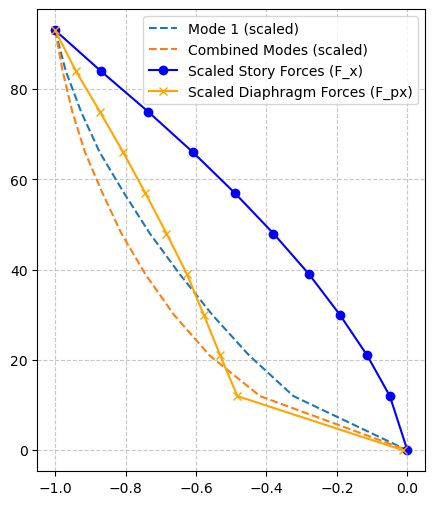

In [99]:
# Plot scaled mode shapes and compare with scaled story and diaphragm forces with story elevation on y-axis
plt.figure(figsize=(5, 6))
# for i, mode_shape in enumerate(mode_shape_df1_scaled.columns):
#     plt.plot(
#         mode_shape_df1_scaled[mode_shape][:-1],
#         building.story_elevations[::-1], 
#         label=f"Mode {i+1} (scaled)", 
#         linestyle='--'
#     )
    
plt.plot(
        mode_shape_df1_scaled["Mode_1"],
        building.story_elevations[::-1], 
        label=f"Mode {1} (scaled)", 
        linestyle='--'
    )

plt.plot(
        scaled_combined_modal_shape,
        building.story_elevations[::-1], 
        label=f"Combined Modes (scaled)", 
        linestyle='--'
    )

plt.plot(
    -Fx_scaled,
    building.story_elevations,  
    label="Scaled Story Forces (F_x)", 
    color='blue', 
    marker='o'
)

plt.plot(
    -Fpx_scaled, 
    building.story_elevations, 
    label="Scaled Diaphragm Forces (F_px)", 
    color='orange', 
    marker='x'
)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)